In [1]:
import os,sys,boto3,json,xmltodict,itertools,subprocess
from botocore.client import Config
import midas.file_reader
from pprint import pprint
import numpy as np

# /////////////////////////////////////////
def GetBanksData(filename):
    reader = midas.file_reader.MidasFile(filename)
    for E,evt in enumerate(reader):
      for bank_name, bank in evt.banks.items():
        yield (evt, bank)

# ///////////////////////////////////////////////////////////////////
def LoadXML(filename):
	with open(filename, 'rt') as file: 
		body = file.read() 
	return 

# ///////////////////////////////////////////////////////////////////
def Merge(d1, d2):
    return {**d1, **d2} if d1 and d2 else (d1 or d2)

# ///////////////////////////////////////////////////////////////////
def Concat(v):
    return np.array(itertools.chain.from_iterable(v))


# /////////////////////////////////////////
def ParseEvent(evt):

    ret={}

    ret["header"]={
        "event_id": evt.header.event_id,  # int
        "trigger_mask": evt.header.trigger_mask,  # int
        "serial_number":evt.header.serial_number,  # int
        "timestamp": evt.header.timestamp,  # int UNIX timestamp of event
        "event_data_size_bytes": evt.header.event_data_size_bytes,  # int Size of all banks
    }
    ret["all_bank_size_bytes"]=evt.all_bank_size_bytes  # (int)
    ret["flags"]=evt.flags
    ret["non_bank_data"]=evt.non_bank_data # (bytes or None) - Content of some special events that don't
    
    ret["banks"]={}
    for bank_name, bank in evt.banks.items():
        ret["banks"][bank.name]={
            "name": bank.name,  # (str) - 4 characters
            "type": bank.type,  # (int) - See `TID_xxx` members in `midas` module
            "size_bytes": bank.size_bytes,  # (int)
            "data": bank.data # (tuple of int/float/byte etc, or a numpy array if use_numpy is specified when unpacking),
        }

    return ret

# ////////////////////////////////////////////////////////////////
def Shell(cmd):
	return subprocess.check_output(cmd, shell=True, text=True)

# /////////////////////////////////////////
def ConnectS3(bucket_name=None, endpoint_url=None,aws_access_key_id=None, aws_secret_access_key=None, signature_version = None):
    config = Config(signature_version = signature_version)
    s3 = boto3.resource('s3', endpoint_url=endpoint_url, aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, config=config,)
    bucket = s3.Bucket(bucket_name)
    return bucket

# /////////////////////////////////////////
def ParseXML(body):
    d=xmltodict.parse(body) 
    assert(isinstance(d,dict))
    return d

# /////////////////////////////////////////
def SaveXML(filename, data):
    os.makedirs(os.path.dirname(filename),exist_ok=True)
    with open(filename,"wb") as out: out.write(data)


# /////////////////////////////////////////
def SaveBinary(filename, data):
    os.makedirs(os.path.dirname(filename),exist_ok=True)
    with open(filename,"wb") as out: out.write(data)

# /////////////////////////////////////////
def SaveArray(filename, data):
    os.makedirs(os.path.dirname(filename),exist_ok=True)
    np.savez_compressed(filename, data=data)

# /////////////////////////////////////////
def SaveJSON(filename,d):
    os.makedirs(os.path.dirname(filename),exist_ok=True)
    with open(json_filename,"w") as out:
        out.write(d)


# ///////////////////////////////////////////////////////////////
os.makedirs("supercdms-data",exist_ok=True)

endpoint_url="https://maritime.sealstorage.io/api/v0/s3"

if not os.path.isfile("list.txt"):
    Shell(f"aws s3 --profile slac_public --endpoint-url {endpoint_url} --no-verify-ssl ls --recursive s3://utah/supercdms-data/CDMS/UMN/R68/Raw/  | awk '{print $4}' > supercdms-data/list.txt")


# ///////////////////////////////////////////////////////////////
bucket=ConnectS3("utah", endpoint_url,'any','any','s3v4')
max_files=1
pulses={}
    
with open("supercdms-data/list.txt","r") as f:
  files=[it.strip() for it in f.readlines() if it.strip().endswith(".mid.gz")]
print("found",len(files),".mid.gz files")
        
for I,key in enumerate(files):

    if max_files and I>=max_files:
        break
            
    key_noext=key.replace(".mid.gz","")

    # download file
    if not os.path.isfile(key):
        os.makedirs(os.path.dirname(key),exist_ok=True)
        bucket.download_file(key,key)
        print(f"Downloaded file {key} {os.path.getsize(key)}")
    else:
        # print(f"File {key} already exists {os.path.getsize(key)}")
        pass

    # generate json
    if True or not os.path.isfile(key_noext+".json"):
        reader = midas.file_reader.MidasFile(key)
        events=[]
        for E,evt in enumerate(reader):
            parsed=ParseEvent(evt)
        
            # parse xml
            non_bank_data=parsed["non_bank_data"]
            if non_bank_data:
                if non_bank_data[0:5]==b"<?xml":
                    sub_key=f"{key_noext}/events/{E:05d}/non_bank_data.xml"
                    SaveXML(sub_key,non_bank_data)
                else:
                    sub_key=f"{key_noext}/events/{E:05d}/non_bank_data.bin"
                    SaveBinary(sub_key,non_bank_data)
                parsed["non_bank_data"]={"key":sub_key}
            else:
                del parsed["non_bank_data"]

            # streamable
            for bank_name, bank in parsed["banks"].items():
                data=bank["data"]
                if data: 
                    data=np.array(data)
                    sub_key=f"{key_noext}/events/{E:05d}/banks/{bank_name}/data.npz"
                    SaveArray(sub_key,data)
                    bank["data"]={
                        "key":sub_key, 
                        "shape": str(data.shape),
                        "dtype": str(data.dtype),
                        "vmin": str(np.min(data)),
                        "vmax": str(np.max(data))
                    } 
                else:
                    del bank["data"]
                    
            events.append(parsed)

        # save json
        d=json.dumps(events, sort_keys=False, indent=2)
        json_filename=f"{key_noext}.json"
        SaveJSON(json_filename,d)

        # if you want compressed
        uncompressed_size=os.path.getsize(json_filename)
        #Shell(f"gzip --keep --force {json_filename}")
        #compressed_size=os.path.getsize(json_filename + '.gz')
        #print("JSON size size", f"{uncompressed_size:,}",f"{compressed_size:,}")

    print("Done",key,f"{uncompressed_size:,}")

found 39522 .mid.gz files
Done supercdms-data/CDMS/UMN/R68/Raw/07180808_1558/07180808_1558_F0001.mid.gz 671,710


In [ ]:
import glob
pulses=[]
for it in glob.glob("supercdms-data/**/data.npz",recursive=True):
  pulses.append(np.array(np.load(it)["data"]))
pulse=np.concatenate(pulses)
vmin=np.min(pulse)
vmax=np.max(pulse)
print("dtype",pulse.dtype,"shape", pulse.shape,"vmin",vmin,"vmax",vmax)

In [ ]:
import shutil
import numpy as np
import OpenVisus as ov
idx_filename='/mnt/c/big/visus-datasets/signal1d_slac/visus.idx'

N=pulse.shape[0]
shutil.rmtree(os.path.splitext(os.path.dirname(idx_filename))[0], ignore_errors=True)
db=ov.CreateIdx(
  url=idx_filename, 
  dims=[N],
  fields=[ov.Field('data',ov.DType.fromString(str(pulse.dtype)),'row_major')], 
  compression="raw", 
  arco=f"{4*1024*1024}")
assert(os.path.isfile(idx_filename))

print("Writing data...")
logic_box=logic_box=ov.BoxNi(ov.PointNi([0]),ov.PointNi([N]))
db.write(pulse,  logic_box=logic_box)
print("write uncompressed data done","logic_box",logic_box.toString())

In [ ]:
print("Compressing data")
db=ov.LoadDataset(idx_filename)
db.compressDataset("zip") 
print("compress dataset done")

Read data

In [3]:
import OpenVisus as ov
import numpy as np
idx_filename='/mnt/c/big/visus-datasets/signal1d_slac/visus.idx'
db=ov.LoadDataset(idx_filename)
logic_box=db.getLogicBox()
print("logic_box",logic_box)
print("db.getMaxResolution()",db.getMaxResolution())
resolution=12
data=db.read(logic_box=logic_box, max_resolution=resolution)
print(f"IDX read done dtype={data.dtype} shape={data.shape} vmin={np.min(data)} vmax={np.max(data)}")


#full_res=db.read()
#np.save("fullres.npy",full_res)

logic_box ([0], [35022570])
db.getMaxResolution() 26
IDX read done dtype=int64 shape=(2138,) vmin=0 vmax=3221225488


Show data

In [4]:
import bokeh
import bokeh.io 
bokeh.io.output_notebook()

Loading BokehJS ...

In [5]:
from bokeh.plotting import figure, show
p = bokeh.plotting.figure(title="Simple line example", x_axis_label='x', y_axis_label='y')
y=data
x=list(range(len(y)))
p.line(x, y, legend_label="Pulse", line_width=1)
show(p)

Copy blocks to S3. For example:


```bash
aws s3 sync --no-verify-ssl --endpoint-url https://maritime.sealstorage.io/api/v0/s3 --profile sealstorage --size-only  C:/big/visus-datasets/signal1d_slac/ s3://utah/visus-datasets/signal1d_slac/
```

# With `max` filter

In [ ]:
idx_filename_max='/mnt/c/big/visus-datasets/signal1d_slac_max/visus.idx'
shutil.rmtree(os.path.splitext(idx_filename_max)[0], ignore_errors=True)
field=ov.Field('data',f"int64[2]",'row_major')
N=pulse.shape[0]

db=ov.CreateIdx(url=idx_filename_max, 
  dim=1, 
  dims=[N],
  fields=[field], 
  compression="raw",
  filters=['max'],
  arco=2*1024*1024
)
assert(os.path.isfile(idx_filename_max))

print(f"Source pulse dtype={pulse.dtype} shape={pulse.shape} vmin={np.min(pulse):,} vmax={np.max(pulse)}")
pulse_max=np.zeros((N, 2), dtype=pulse.dtype)
pulse_max[:,0]=pulse[:]
vmin,vmax=np.min(pulse_max[:,0]),np.max(pulse_max[:,0])
print(f"New pulse with extra channel shape={pulse_max.shape} dtype={pulse_max.dtype} vmin={vmin:,} vmax={vmax:,}")

print("Writing data...")
logic_box=ov.BoxNi(ov.PointNi([0]),ov.PointNi([N]))
db.write(pulse_max, logic_box=logic_box)
print(f"written max pulse logic_box=[{logic_box.toString()}]")

Compute filter (SLOW OPERATION even ~8 minutes!)

In [ ]:
GB=1024*1024*1024
db.computeFilter(db.getField(), 1*GB)
print("Filter computed")

In [ ]:
print("Compressing data...")
db.compressDataset("zip") 
print("compress dataset done")

Show subsampled and max:

In [ ]:
db_id =ov.LoadDataset('/mnt/c/big/visus-datasets/signal1d_slac/visus.idx'    )
db_max=ov.LoadDataset('/mnt/c/big/visus-datasets/signal1d_slac_max/visus.idx')
logic_box=db_id.getLogicBox()
resolution=8
data_sub=db_id .read(logic_box=logic_box, max_resolution=resolution)
data_max=db_max.read(logic_box=logic_box, max_resolution=resolution)[:,0]
print(f"read id  dtype={data_sub.dtype } shape={data_sub.shape } vmin={np.min(data_sub) } vmax={np.max(data_sub )}")
print(f"read max dtype={data_max.dtype} shape={data_max.shape} vmin={np.min(data_max)} vmax={np.max(data_max)}")
p = bokeh.plotting.figure(title="Simple line example", x_axis_label='x', y_axis_label='y')
p.line(list(range(len(data_sub))), data_sub, legend_label="sub", line_width=1, color="blue" );p.circle(list(range(len(data_sub))),data_sub, color="blue" )
p.line(list(range(len(data_max))), data_max, legend_label="max", line_width=1, color="green");p.circle(list(range(len(data_max))),data_max, color="green")
bokeh.io.show(p, notebook_handle=True)

Copy blocks to S3. For example:


```bash
aws s3 sync --no-verify-ssl --endpoint-url https://maritime.sealstorage.io/api/v0/s3 --profile sealstorage --size-only  C:/big/visus-datasets/signal1d_slac_max/ s3://utah/visus-datasets/signal1d_slac_max/
```

# Valerio's period signal

In [7]:
import numpy as np
import scipy 
range0 = 128
samples = range0*range0*range0*range0
x = np.linspace(0, 1, samples)
range1 = range0        ;y1 = range1 *scipy.signal.sawtooth((samples/range1) * np.pi * 5 * x)
range2 = range1 *range0;y2 = range2 *scipy.signal.square  ((samples/range2) * np.pi * 5 * x)
range3 = range2 *range0;y3 = range3 *scipy.signal.sawtooth((samples/range3) * np.pi * 5 * x, 0.5)
range4 = range3 *range0;y4 = (range4 //16) *np.sin  ((samples/range4) * np.pi * 8 * x)
y = y1 + y2 +y3 + y4

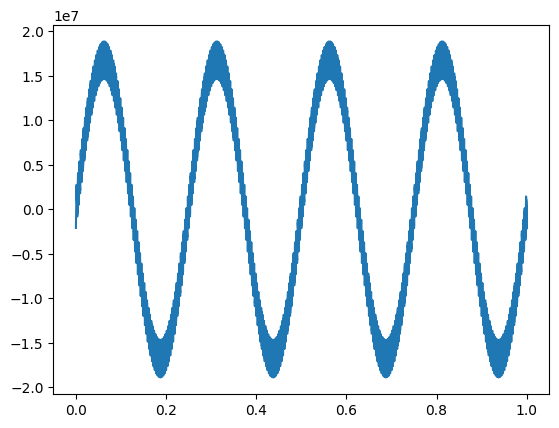

In [14]:
#This is only to plot a little piece
import matplotlib.pyplot as plt

plt.plot(x[::256], y[::256])

In [10]:
import shutil,os,sys
import numpy as np
import OpenVisus as ov
idx_filename='/mnt/c/big/visus-datasets/signal1d_periodic/visus.idx'

pulse=y
N=pulse.shape[0]
shutil.rmtree(os.path.splitext(os.path.dirname(idx_filename))[0], ignore_errors=True)
db=ov.CreateIdx(url=idx_filename,  dims=[N], fields=[ov.Field('data',ov.DType.fromString(str(pulse.dtype)),'row_major')], compression="raw", arco=f"{4*1024*1024}")

print("Writing IDX data...")
logic_box=logic_box=ov.BoxNi(ov.PointNi([0]),ov.PointNi([N]))
db.write(pulse, logic_box=logic_box)
print("write uncompressed data done","logic_box",logic_box.toString())

print("Compressing data")
db=ov.LoadDataset(idx_filename)
db.compressDataset("zip") 
print("compress dataset done")

# aws s3 sync --no-verify-ssl --endpoint-url https://maritime.sealstorage.io/api/v0/s3 --profile sealstorage --size-only  C:/big/visus-datasets/signal1d_periodic/ s3://utah/visus-datasets/signal1d_periodic/

Writing IDX data...
write uncompressed data done logic_box 0 268435456
Compressing data
compress dataset done
